# Semi-supervised surgery pipeline with SCANVI

In [76]:
import os
import gdown

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import scanpy as sc
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity

In [77]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### IMPORTANT THIS IS WHERE WE CHOOSE THE CELL TYPE LABEL TO TRAIN ON

In [78]:
condition_key = 'sample'
cell_type_key = 'cell_type_tumor'

## Set relevant anndata.obs labels and training length

In [84]:
adata = sc.read_h5ad('/root/datos/maestria/netopaas/luca/data/atlas/extended_tumor_ext.h5ad')

In [85]:
adata

AnnData object with n_obs × n_vars = 65895 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'utx_level', 'cell_id'

In [86]:
adata = adata[(adata.obs.origin == 'tumor_primary')]


# stages = ['III','III or IV', 'IV']
stages = ['I','II','III','III or IV', 'IV']
adata = adata[adata.obs.uicc_stage.isin(stages)]

# we remove these because some are enriched for endotheliar and some for immune cells
studies = ['Goveia_Carmeliet_2020','Leader_Merad_2021','Guo_Zhang_2018']
adata = adata[~adata.obs.study.isin(studies)]


In [99]:
adata = adata[:, adata.var.is_highly_variable == 'True']

In [100]:
import gc
del adata.raw
gc.collect()

del adata.layers['counts_length_scaled']
adata.X = adata.layers['count'].copy()

In [101]:
adata = remove_sparsity(adata)
source_adata = adata

## Create SCANVI model and train it on fully labelled reference dataset

In [103]:
sca.models.SCVI.setup_anndata(source_adata, batch_key=condition_key, labels_key=cell_type_key)

/usr/local/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:189: UserWarning: Category 55 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/usr/local/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:189: UserWarning: Category 11 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [126]:
vae2 = sca.models.SCVI(
    source_adata,
    n_layers=3,
    n_latent=20,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [127]:
vae2.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/128:   0%|                                                                                                                                                                         | 0/128 [00:00<?, ?it/s]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/128:   1%|▊                                                                                                    | 1/128 [00:07<16:40,  7.88s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=2.19e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 3/128:   2%|█▌                                                                                                   | 2/128 [00:15<16:34,  7.89s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.94e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 4/128:   2%|██▎                                                                                                  | 3/128 [00:23<16:32,  7.94s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 5/128:   3%|███▏                                                                                                 | 4/128 [00:31<16:28,  7.97s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.84e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/128:   4%|███▉                                                                                                  | 5/128 [00:39<16:20,  7.97s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.82e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 7/128:   5%|████▋                                                                                                | 6/128 [00:47<16:00,  7.88s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=1.81e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 8/128:   5%|█████▌                                                                                                | 7/128 [00:55<15:55,  7.90s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=1.8e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 9/128:   6%|██████▎                                                                                              | 8/128 [01:03<15:49,  7.91s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=1.79e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 10/128:   7%|███████                                                                                             | 9/128 [01:11<15:47,  7.97s/it, v_num=1, train_loss_step=1.61e+3, train_loss_epoch=1.78e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 11/128:   8%|███████▋                                                                                           | 10/128 [01:19<15:38,  7.95s/it, v_num=1, train_loss_step=2.29e+3, train_loss_epoch=1.78e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 12/128:   9%|████████▌                                                                                          | 11/128 [01:27<15:30,  7.95s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.77e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 13/128:   9%|█████████▎                                                                                         | 12/128 [01:35<15:21,  7.94s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.77e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 14/128:  10%|██████████                                                                                         | 13/128 [01:43<15:11,  7.92s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=1.77e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 15/128:  11%|██████████▊                                                                                        | 14/128 [01:51<15:06,  7.95s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=1.77e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 16/128:  12%|███████████▌                                                                                       | 15/128 [01:59<14:55,  7.93s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=1.76e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 17/128:  12%|████████████▍                                                                                      | 16/128 [02:06<14:43,  7.89s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=1.76e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 18/128:  13%|█████████████▏                                                                                     | 17/128 [02:14<14:31,  7.85s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.76e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 19/128:  14%|█████████████▉                                                                                     | 18/128 [02:22<14:20,  7.83s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.76e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 20/128:  15%|██████████████▋                                                                                    | 19/128 [02:30<14:18,  7.87s/it, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.76e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 21/128:  16%|███████████████▍                                                                                   | 20/128 [02:38<14:11,  7.88s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.76e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 22/128:  16%|████████████████▍                                                                                   | 21/128 [02:46<14:02,  7.87s/it, v_num=1, train_loss_step=1.6e+3, train_loss_epoch=1.76e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 23/128:  17%|█████████████████                                                                                  | 22/128 [02:53<13:55,  7.89s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.75e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 24/128:  18%|█████████████████▊                                                                                 | 23/128 [03:01<13:47,  7.88s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.75e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 25/128:  19%|██████████████████▌                                                                                | 24/128 [03:09<13:42,  7.91s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=1.75e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 26/128:  20%|███████████████████▎                                                                               | 25/128 [03:17<13:37,  7.94s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=1.75e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 27/128:  20%|████████████████████                                                                               | 26/128 [03:25<13:26,  7.91s/it, v_num=1, train_loss_step=1.62e+3, train_loss_epoch=1.75e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 28/128:  21%|████████████████████▉                                                                              | 27/128 [03:33<13:21,  7.94s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.75e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 29/128:  22%|█████████████████████▋                                                                             | 28/128 [03:41<13:13,  7.94s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.75e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 30/128:  23%|██████████████████████▍                                                                            | 29/128 [03:49<13:07,  7.95s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.75e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 31/128:  23%|███████████████████████▏                                                                           | 30/128 [03:57<13:03,  8.00s/it, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.75e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 32/128:  24%|███████████████████████▉                                                                           | 31/128 [04:05<12:53,  7.97s/it, v_num=1, train_loss_step=1.37e+3, train_loss_epoch=1.75e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 33/128:  25%|████████████████████████▊                                                                          | 32/128 [04:13<12:47,  7.99s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=1.75e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 34/128:  26%|█████████████████████████▌                                                                         | 33/128 [04:21<12:41,  8.01s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.75e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 35/128:  27%|██████████████████████████▎                                                                        | 34/128 [04:29<12:28,  7.96s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.75e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 36/128:  27%|███████████████████████████                                                                        | 35/128 [04:37<12:24,  8.00s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=1.75e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 37/128:  28%|███████████████████████████▊                                                                       | 36/128 [04:45<12:12,  7.96s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.75e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 38/128:  29%|████████████████████████████▌                                                                      | 37/128 [04:53<12:05,  7.97s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 39/128:  30%|█████████████████████████████▍                                                                     | 38/128 [05:01<12:00,  8.00s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 40/128:  30%|██████████████████████████████▍                                                                     | 39/128 [05:09<11:49,  7.97s/it, v_num=1, train_loss_step=1.6e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 41/128:  31%|██████████████████████████████▉                                                                    | 40/128 [05:17<11:41,  7.98s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 42/128:  32%|███████████████████████████████▋                                                                   | 41/128 [05:25<11:33,  7.97s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 43/128:  33%|████████████████████████████████▍                                                                  | 42/128 [05:33<11:24,  7.96s/it, v_num=1, train_loss_step=1.64e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 44/128:  34%|█████████████████████████████████▎                                                                 | 43/128 [05:41<11:19,  7.99s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 45/128:  34%|██████████████████████████████████                                                                 | 44/128 [05:49<11:09,  7.97s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 46/128:  35%|██████████████████████████████████▊                                                                | 45/128 [05:57<11:01,  7.97s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 47/128:  36%|███████████████████████████████████▌                                                               | 46/128 [06:05<10:55,  8.00s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 48/128:  37%|████████████████████████████████████▎                                                              | 47/128 [06:13<10:44,  7.96s/it, v_num=1, train_loss_step=2.29e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 49/128:  38%|█████████████████████████████████████▏                                                             | 48/128 [06:21<10:37,  7.97s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 50/128:  38%|█████████████████████████████████████▉                                                             | 49/128 [06:29<10:30,  7.98s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 51/128:  39%|██████████████████████████████████████▋                                                            | 50/128 [06:37<10:21,  7.96s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 52/128:  40%|███████████████████████████████████████▍                                                           | 51/128 [06:45<10:15,  8.00s/it, v_num=1, train_loss_step=1.62e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 53/128:  41%|████████████████████████████████████████▏                                                          | 52/128 [06:53<10:05,  7.97s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 54/128:  41%|████████████████████████████████████████▉                                                          | 53/128 [07:01<09:58,  7.98s/it, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 55/128:  42%|█████████████████████████████████████████▊                                                         | 54/128 [07:09<09:50,  7.99s/it, v_num=1, train_loss_step=1.57e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 56/128:  43%|██████████████████████████████████████████▌                                                        | 55/128 [07:17<09:40,  7.96s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 57/128:  44%|███████████████████████████████████████████▎                                                       | 56/128 [07:25<09:34,  7.98s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 58/128:  45%|████████████████████████████████████████████▌                                                       | 57/128 [07:33<09:26,  7.98s/it, v_num=1, train_loss_step=1.6e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 59/128:  45%|████████████████████████████████████████████▊                                                      | 58/128 [07:41<09:17,  7.97s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 60/128:  46%|█████████████████████████████████████████████▋                                                     | 59/128 [07:49<09:14,  8.03s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 61/128:  47%|██████████████████████████████████████████████▍                                                    | 60/128 [07:57<09:04,  8.00s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 62/128:  48%|███████████████████████████████████████████████▏                                                   | 61/128 [08:04<08:53,  7.96s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 63/128:  48%|█████████████████████████████████████████████████▍                                                    | 62/128 [08:13<08:47,  7.99s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 64/128:  49%|████████████████████████████████████████████████▋                                                  | 63/128 [08:20<08:36,  7.95s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 65/128:  50%|█████████████████████████████████████████████████▌                                                 | 64/128 [08:28<08:31,  7.99s/it, v_num=1, train_loss_step=1.62e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 66/128:  51%|██████████████████████████████████████████████████▎                                                | 65/128 [08:36<08:22,  7.98s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 67/128:  52%|███████████████████████████████████████████████████                                                | 66/128 [08:44<08:13,  7.97s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 68/128:  52%|███████████████████████████████████████████████████▊                                               | 67/128 [08:52<08:07,  7.99s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 69/128:  53%|████████████████████████████████████████████████████▌                                              | 68/128 [09:00<07:56,  7.95s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 70/128:  54%|█████████████████████████████████████████████████████▉                                              | 69/128 [09:08<07:48,  7.94s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 71/128:  55%|██████████████████████████████████████████████████████▏                                            | 70/128 [09:16<07:38,  7.90s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 72/128:  55%|███████████████████████████████████████████████████████▍                                            | 71/128 [09:24<07:27,  7.85s/it, v_num=1, train_loss_step=1.6e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 73/128:  56%|███████████████████████████████████████████████████████▋                                           | 72/128 [09:32<07:20,  7.86s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 74/128:  57%|████████████████████████████████████████████████████████▍                                          | 73/128 [09:39<07:12,  7.86s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 75/128:  58%|█████████████████████████████████████████████████████████▏                                         | 74/128 [09:47<07:03,  7.85s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 76/128:  59%|██████████████████████████████████████████████████████████▌                                         | 75/128 [09:55<06:56,  7.86s/it, v_num=1, train_loss_step=1.6e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 77/128:  59%|██████████████████████████████████████████████████████████▊                                        | 76/128 [10:03<06:47,  7.84s/it, v_num=1, train_loss_step=1.45e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 78/128:  60%|███████████████████████████████████████████████████████████▌                                       | 77/128 [10:11<06:41,  7.87s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 79/128:  61%|████████████████████████████████████████████████████████████▎                                      | 78/128 [10:19<06:35,  7.90s/it, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 80/128:  62%|█████████████████████████████████████████████████████████████                                      | 79/128 [10:27<06:27,  7.91s/it, v_num=1, train_loss_step=1.56e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 81/128:  62%|█████████████████████████████████████████████████████████████▉                                     | 80/128 [10:35<06:22,  7.98s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 82/128:  63%|██████████████████████████████████████████████████████████████▋                                    | 81/128 [10:43<06:14,  7.97s/it, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 83/128:  64%|███████████████████████████████████████████████████████████████▍                                   | 82/128 [10:51<06:06,  7.98s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 84/128:  65%|████████████████████████████████████████████████████████████████▊                                   | 83/128 [10:59<06:00,  8.00s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 85/128:  66%|████████████████████████████████████████████████████████████████▉                                  | 84/128 [11:07<05:50,  7.97s/it, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 86/128:  66%|█████████████████████████████████████████████████████████████████▋                                 | 85/128 [11:15<05:42,  7.97s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 87/128:  67%|██████████████████████████████████████████████████████████████████▌                                | 86/128 [11:23<05:33,  7.94s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 88/128:  68%|███████████████████████████████████████████████████████████████████▎                               | 87/128 [11:31<05:25,  7.94s/it, v_num=1, train_loss_step=1.31e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 89/128:  69%|████████████████████████████████████████████████████████████████████                               | 88/128 [11:39<05:19,  7.99s/it, v_num=1, train_loss_step=1.52e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 90/128:  70%|████████████████████████████████████████████████████████████████████▊                              | 89/128 [11:47<05:10,  7.97s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 91/128:  70%|█████████████████████████████████████████████████████████████████████▌                             | 90/128 [11:55<05:03,  7.97s/it, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 92/128:  71%|██████████████████████████████████████████████████████████████████████▍                            | 91/128 [12:03<04:55,  7.98s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 93/128:  72%|███████████████████████████████████████████████████████████████████████▏                           | 92/128 [12:10<04:45,  7.94s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 94/128:  73%|███████████████████████████████████████████████████████████████████████▉                           | 93/128 [12:19<04:39,  8.00s/it, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 95/128:  73%|█████████████████████████████████████████████████████████████████████████▍                          | 94/128 [12:27<04:31,  7.99s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 96/128:  74%|█████████████████████████████████████████████████████████████████████████▍                         | 95/128 [12:34<04:22,  7.97s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 97/128:  75%|██████████████████████████████████████████████████████████████████████████▎                        | 96/128 [12:43<04:16,  8.01s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 98/128:  76%|███████████████████████████████████████████████████████████████████████████                        | 97/128 [12:50<04:07,  7.97s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 99/128:  77%|███████████████████████████████████████████████████████████████████████████▊                       | 98/128 [12:58<03:58,  7.96s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 100/128:  77%|███████████████████████████████████████████████████████████████████████████▊                      | 99/128 [13:06<03:51,  7.98s/it, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 101/128:  78%|███████████████████████████████████████████████████████████████████████████▊                     | 100/128 [13:14<03:42,  7.96s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 102/128:  79%|████████████████████████████████████████████████████████████████████████████▌                    | 101/128 [13:22<03:36,  8.01s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 103/128:  80%|█████████████████████████████████████████████████████████████████████████████▎                   | 102/128 [13:30<03:27,  7.98s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 104/128:  80%|██████████████████████████████████████████████████████████████████████████████▊                   | 103/128 [13:38<03:19,  8.00s/it, v_num=1, train_loss_step=2.3e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 105/128:  81%|██████████████████████████████████████████████████████████████████████████████▊                  | 104/128 [13:46<03:12,  8.00s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 106/128:  82%|███████████████████████████████████████████████████████████████████████████████▌                 | 105/128 [13:54<03:03,  7.97s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 107/128:  83%|████████████████████████████████████████████████████████████████████████████████▎                | 106/128 [14:02<02:55,  7.98s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 108/128:  84%|█████████████████████████████████████████████████████████████████████████████████                | 107/128 [14:10<02:47,  7.98s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 109/128:  84%|█████████████████████████████████████████████████████████████████████████████████▊               | 108/128 [14:18<02:38,  7.94s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 110/128:  85%|██████████████████████████████████████████████████████████████████████████████████▌              | 109/128 [14:26<02:31,  7.98s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 111/128:  86%|███████████████████████████████████████████████████████████████████████████████████▎             | 110/128 [14:34<02:23,  7.95s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 112/128:  87%|████████████████████████████████████████████████████████████████████████████████████             | 111/128 [14:42<02:15,  7.97s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 113/128:  88%|████████████████████████████████████████████████████████████████████████████████████▉            | 112/128 [14:50<02:07,  7.99s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 114/128:  88%|█████████████████████████████████████████████████████████████████████████████████████▋           | 113/128 [14:58<01:59,  7.96s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 115/128:  89%|██████████████████████████████████████████████████████████████████████████████████████▍          | 114/128 [15:06<01:51,  7.99s/it, v_num=1, train_loss_step=1.62e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 116/128:  90%|███████████████████████████████████████████████████████████████████████████████████████▏         | 115/128 [15:14<01:43,  7.97s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 117/128:  91%|███████████████████████████████████████████████████████████████████████████████████████▉         | 116/128 [15:22<01:35,  7.97s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 118/128:  91%|████████████████████████████████████████████████████████████████████████████████████████▋        | 117/128 [15:30<01:28,  8.00s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 119/128:  92%|█████████████████████████████████████████████████████████████████████████████████████████▍       | 118/128 [15:38<01:19,  7.95s/it, v_num=1, train_loss_step=1.36e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 120/128:  93%|██████████████████████████████████████████████████████████████████████████████████████████▏      | 119/128 [15:46<01:11,  7.97s/it, v_num=1, train_loss_step=1.32e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 121/128:  94%|██████████████████████████████████████████████████████████████████████████████████████████▉      | 120/128 [15:54<01:03,  7.98s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 122/128:  95%|███████████████████████████████████████████████████████████████████████████████████████████▋     | 121/128 [16:02<00:55,  7.95s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 123/128:  95%|████████████████████████████████████████████████████████████████████████████████████████████▍    | 122/128 [16:10<00:47,  7.98s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 124/128:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▏   | 123/128 [16:18<00:39,  7.99s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 125/128:  97%|█████████████████████████████████████████████████████████████████████████████████████████████▉   | 124/128 [16:26<00:31,  7.98s/it, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 126/128:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▋  | 125/128 [16:34<00:24,  8.00s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 127/128:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▍ | 126/128 [16:42<00:15,  7.98s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 128/128:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▏| 127/128 [16:50<00:07,  7.99s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.74e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 128/128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [16:58<00:00,  8.00s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.74e+3]

INFO: `Trainer.fit` stopped: `max_epochs=128` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=128` reached.


Epoch 128/128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [16:58<00:00,  7.96s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.74e+3]


In [135]:
vae2

SCVI Model with the following params: 
n_hidden: 128, n_latent: 20, n_layers: 3, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [125]:
# import torch.optim as optim
# from torch.optim.lr_scheduler import StepLR
# # Define the optimizer
# initial_lr = 1e-3
# optimizer = optim.Adam(vae.parameters(), lr=initial_lr)

# # Define the learning rate scheduler
# step_size = 10
# gamma = 0.1
# scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

# # Custom training loop
# max_epochs = 2
# for epoch in range(max_epochs):
#     vae.train(max_epochs=1, plan_kwargs={"optim_kwargs": {"optimizer": optimizer}})
#     scheduler.step()

#     # Optionally, log the learning rate and other metrics
#     current_lr = scheduler.get_last_lr()[0]
#     print(f"Epoch {epoch + 1}, Learning Rate: {current_lr}")

AttributeError: 'SCVI' object has no attribute 'parameters'

In [136]:
scanvae2 = sca.models.SCANVI.from_scvi_model(vae2, unlabeled_category = "Unknown")

/usr/local/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:189: UserWarning: Category 55 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/usr/local/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:189: UserWarning: Category 11 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/usr/local/lib/python3.11/site-packages/scvi/data/fields/_scanvi.py:58: UserWarning: Category 11 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [107]:
print("Labelled Indices: ", len(scanvae._labeled_indices))
print("Unlabelled Indices: ", len(scanvae._unlabeled_indices))

Labelled Indices:  62508
Unlabelled Indices:  0


In [188]:
scanvae2.train(max_epochs=300)

INFO     Training for 300 epochs.                                                                                  


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/300:   0%|                                                                                                                                                                         | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 2/300:   0%|▎                                                                                                  | 1/300 [00:19<1:35:52, 19.24s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 3/300:   1%|▋                                                                                                  | 2/300 [00:38<1:34:55, 19.11s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 4/300:   1%|▉                                                                                                  | 3/300 [00:57<1:34:07, 19.01s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 5/300:   1%|█▎                                                                                                 | 4/300 [01:16<1:34:19, 19.12s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 6/300:   2%|█▋                                                                                                 | 5/300 [01:35<1:33:45, 19.07s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 7/300:   2%|██                                                                                                  | 6/300 [01:54<1:33:15, 19.03s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 8/300:   2%|██▎                                                                                                | 7/300 [02:13<1:33:27, 19.14s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 9/300:   3%|██▋                                                                                                | 8/300 [02:32<1:32:47, 19.07s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 10/300:   3%|██▉                                                                                               | 9/300 [02:51<1:32:24, 19.05s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 11/300:   3%|███▏                                                                                             | 10/300 [03:10<1:32:16, 19.09s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 12/300:   4%|███▌                                                                                              | 11/300 [03:29<1:31:44, 19.05s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 13/300:   4%|███▉                                                                                             | 12/300 [03:48<1:31:23, 19.04s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 14/300:   4%|████▏                                                                                             | 13/300 [04:07<1:31:06, 19.05s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 15/300:   5%|████▌                                                                                            | 14/300 [04:26<1:30:35, 19.00s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 16/300:   5%|████▊                                                                                            | 15/300 [04:46<1:30:35, 19.07s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 17/300:   5%|█████▏                                                                                           | 16/300 [05:05<1:30:12, 19.06s/it, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 18/300:   6%|█████▍                                                                                           | 17/300 [05:23<1:29:43, 19.02s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 19/300:   6%|█████▊                                                                                           | 18/300 [05:43<1:29:50, 19.12s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 20/300:   6%|██████▏                                                                                          | 19/300 [06:02<1:29:22, 19.08s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 21/300:   7%|██████▍                                                                                          | 20/300 [06:21<1:29:18, 19.14s/it, v_num=1, train_loss_step=1.62e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 22/300:   7%|██████▊                                                                                          | 21/300 [06:41<1:29:30, 19.25s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 23/300:   7%|███████                                                                                          | 22/300 [07:00<1:29:02, 19.22s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 24/300:   8%|███████▍                                                                                         | 23/300 [07:19<1:28:55, 19.26s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 25/300:   8%|███████▊                                                                                          | 24/300 [07:39<1:28:46, 19.30s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 26/300:   8%|████████                                                                                         | 25/300 [07:58<1:28:16, 19.26s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 27/300:   9%|████████▍                                                                                        | 26/300 [08:17<1:27:56, 19.26s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 28/300:   9%|████████▋                                                                                        | 27/300 [08:36<1:27:14, 19.17s/it, v_num=1, train_loss_step=1.64e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 29/300:   9%|█████████                                                                                        | 28/300 [08:55<1:26:37, 19.11s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 30/300:  10%|█████████▍                                                                                       | 29/300 [09:14<1:26:32, 19.16s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 31/300:  10%|█████████▋                                                                                       | 30/300 [09:33<1:25:54, 19.09s/it, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 32/300:  10%|██████████                                                                                       | 31/300 [09:52<1:25:28, 19.06s/it, v_num=1, train_loss_step=1.64e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 33/300:  11%|██████████▎                                                                                      | 32/300 [10:11<1:25:20, 19.11s/it, v_num=1, train_loss_step=1.61e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 34/300:  11%|██████████▋                                                                                      | 33/300 [10:30<1:24:49, 19.06s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 35/300:  11%|██████████▉                                                                                      | 34/300 [10:49<1:24:28, 19.05s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 36/300:  12%|███████████▎                                                                                     | 35/300 [11:08<1:24:19, 19.09s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 37/300:  12%|███████████▋                                                                                     | 36/300 [11:27<1:23:47, 19.04s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 38/300:  12%|███████████▉                                                                                     | 37/300 [11:46<1:23:32, 19.06s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 39/300:  13%|████████████▎                                                                                    | 38/300 [12:06<1:23:27, 19.11s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 40/300:  13%|████████████▌                                                                                    | 39/300 [12:25<1:23:07, 19.11s/it, v_num=1, train_loss_step=2.37e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 41/300:  13%|████████████▉                                                                                    | 40/300 [12:44<1:22:53, 19.13s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 42/300:  14%|█████████████▎                                                                                   | 41/300 [13:03<1:22:37, 19.14s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 43/300:  14%|█████████████▌                                                                                   | 42/300 [13:22<1:21:56, 19.06s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 44/300:  14%|██████████████                                                                                    | 43/300 [13:41<1:21:52, 19.12s/it, v_num=1, train_loss_step=1.6e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 45/300:  15%|██████████████▏                                                                                  | 44/300 [14:00<1:21:37, 19.13s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 46/300:  15%|██████████████▌                                                                                  | 45/300 [14:19<1:20:59, 19.06s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 47/300:  15%|██████████████▊                                                                                  | 46/300 [14:39<1:20:53, 19.11s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 48/300:  16%|███████████████▋                                                                                    | 47/300 [14:58<1:20:23, 19.06s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 49/300:  16%|███████████████▌                                                                                 | 48/300 [15:16<1:19:52, 19.02s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 50/300:  16%|███████████████▊                                                                                 | 49/300 [15:36<1:19:56, 19.11s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 51/300:  17%|████████████████▏                                                                                | 50/300 [15:55<1:19:23, 19.06s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 52/300:  17%|████████████████▍                                                                                | 51/300 [16:14<1:19:06, 19.06s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 53/300:  17%|████████████████▊                                                                                | 52/300 [16:33<1:19:00, 19.11s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 54/300:  18%|█████████████████▏                                                                               | 53/300 [16:52<1:18:27, 19.06s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 55/300:  18%|█████████████████▍                                                                               | 54/300 [17:11<1:18:13, 19.08s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 56/300:  18%|█████████████████▊                                                                               | 55/300 [17:30<1:18:10, 19.14s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 57/300:  19%|██████████████████                                                                               | 56/300 [17:49<1:17:38, 19.09s/it, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 58/300:  19%|██████████████████▍                                                                              | 57/300 [18:08<1:17:25, 19.12s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 59/300:  19%|██████████████████▊                                                                              | 58/300 [18:28<1:17:06, 19.12s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 60/300:  20%|███████████████████                                                                              | 59/300 [18:47<1:16:33, 19.06s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 61/300:  20%|███████████████████▍                                                                             | 60/300 [19:06<1:16:24, 19.10s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 62/300:  20%|███████████████████▋                                                                             | 61/300 [19:25<1:15:59, 19.08s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 63/300:  21%|████████████████████                                                                             | 62/300 [19:44<1:15:26, 19.02s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 64/300:  21%|████████████████████▎                                                                            | 63/300 [20:03<1:15:30, 19.12s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 65/300:  21%|████████████████████▋                                                                            | 64/300 [20:22<1:15:03, 19.08s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 66/300:  22%|█████████████████████                                                                            | 65/300 [20:41<1:14:41, 19.07s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 67/300:  22%|█████████████████████▎                                                                           | 66/300 [21:00<1:14:41, 19.15s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 68/300:  22%|█████████████████████▋                                                                           | 67/300 [21:19<1:14:15, 19.12s/it, v_num=1, train_loss_step=1.65e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 69/300:  23%|█████████████████████▉                                                                           | 68/300 [21:39<1:13:59, 19.14s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 70/300:  23%|██████████████████████▎                                                                          | 69/300 [21:58<1:13:45, 19.16s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 71/300:  23%|██████████████████████▋                                                                          | 70/300 [22:17<1:13:11, 19.09s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 72/300:  24%|██████████████████████▉                                                                          | 71/300 [22:36<1:12:52, 19.09s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 73/300:  24%|███████████████████████▎                                                                         | 72/300 [22:55<1:12:35, 19.10s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 74/300:  24%|███████████████████████▌                                                                         | 73/300 [23:14<1:12:07, 19.07s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 75/300:  25%|███████████████████████▉                                                                         | 74/300 [23:33<1:11:55, 19.09s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 76/300:  25%|████████████████████████▎                                                                        | 75/300 [23:53<1:12:03, 19.21s/it, v_num=1, train_loss_step=2.27e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 77/300:  25%|████████████████████████▌                                                                        | 76/300 [24:12<1:11:41, 19.20s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 78/300:  26%|█████████████████████████▏                                                                        | 77/300 [24:31<1:11:10, 19.15s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 79/300:  26%|█████████████████████████▏                                                                       | 78/300 [24:50<1:11:01, 19.20s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 80/300:  26%|█████████████████████████▌                                                                       | 79/300 [25:09<1:10:26, 19.12s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 81/300:  27%|█████████████████████████▊                                                                       | 80/300 [25:28<1:10:18, 19.17s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 82/300:  27%|██████████████████████████▍                                                                       | 81/300 [25:48<1:10:18, 19.26s/it, v_num=1, train_loss_step=1.6e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 83/300:  27%|██████████████████████████▌                                                                      | 82/300 [26:07<1:10:00, 19.27s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 84/300:  28%|██████████████████████████▊                                                                      | 83/300 [26:26<1:09:36, 19.25s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 85/300:  28%|███████████████████████████▏                                                                     | 84/300 [26:46<1:09:27, 19.29s/it, v_num=1, train_loss_step=1.49e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 86/300:  28%|███████████████████████████▍                                                                     | 85/300 [27:05<1:08:58, 19.25s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 87/300:  29%|███████████████████████████▊                                                                     | 86/300 [27:24<1:08:55, 19.32s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 88/300:  29%|████████████████████████████▏                                                                    | 87/300 [27:44<1:08:37, 19.33s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 89/300:  29%|████████████████████████████▍                                                                    | 88/300 [28:03<1:08:09, 19.29s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 90/300:  30%|████████████████████████████▊                                                                    | 89/300 [28:22<1:08:02, 19.35s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 91/300:  30%|█████████████████████████████                                                                    | 90/300 [28:41<1:07:18, 19.23s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 92/300:  30%|█████████████████████████████▍                                                                   | 91/300 [29:00<1:06:53, 19.20s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 93/300:  31%|█████████████████████████████▋                                                                   | 92/300 [29:20<1:06:57, 19.31s/it, v_num=1, train_loss_step=2.34e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 94/300:  31%|██████████████████████████████                                                                   | 93/300 [29:39<1:06:29, 19.27s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 95/300:  31%|██████████████████████████████▍                                                                  | 94/300 [29:59<1:06:12, 19.28s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 96/300:  32%|██████████████████████████████▋                                                                  | 95/300 [30:18<1:06:01, 19.33s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 97/300:  32%|███████████████████████████████                                                                  | 96/300 [30:37<1:05:32, 19.28s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 98/300:  32%|███████████████████████████████▋                                                                  | 97/300 [30:56<1:05:08, 19.26s/it, v_num=1, train_loss_step=1.6e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 99/300:  33%|███████████████████████████████▋                                                                 | 98/300 [31:16<1:04:47, 19.24s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 100/300:  33%|███████████████████████████████▋                                                                | 99/300 [31:34<1:04:10, 19.16s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 101/300:  33%|███████████████████████████████▋                                                               | 100/300 [31:54<1:03:57, 19.19s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 102/300:  34%|███████████████████████████████▉                                                               | 101/300 [32:13<1:03:41, 19.21s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 103/300:  34%|████████████████████████████████▎                                                              | 102/300 [32:32<1:03:22, 19.21s/it, v_num=1, train_loss_step=2.51e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 104/300:  34%|████████████████████████████████▌                                                              | 103/300 [32:52<1:03:22, 19.30s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 105/300:  35%|████████████████████████████████▉                                                              | 104/300 [33:11<1:02:51, 19.24s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 106/300:  35%|█████████████████████████████████▎                                                             | 105/300 [33:30<1:02:25, 19.21s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 107/300:  35%|█████████████████████████████████▌                                                             | 106/300 [33:49<1:01:57, 19.16s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 108/300:  36%|██████████████████████████████████▌                                                              | 107/300 [34:04<57:28, 17.87s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 109/300:  36%|██████████████████████████████████▉                                                              | 108/300 [34:23<58:20, 18.23s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 110/300:  36%|███████████████████████████████████▏                                                             | 109/300 [34:42<58:44, 18.45s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 111/300:  37%|████████████████████████████████████▋                                                               | 110/300 [35:01<58:50, 18.58s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 112/300:  37%|███████████████████████████████████▉                                                             | 111/300 [35:20<59:11, 18.79s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 113/300:  37%|████████████████████████████████████▏                                                            | 112/300 [35:39<58:55, 18.80s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=1.87e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 114/300:  38%|████████████████████████████████████▌                                                            | 113/300 [35:58<58:42, 18.84s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 115/300:  38%|████████████████████████████████████▊                                                            | 114/300 [36:17<58:38, 18.92s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 116/300:  38%|█████████████████████████████████████▏                                                           | 115/300 [36:36<58:08, 18.85s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 117/300:  39%|█████████████████████████████████████▌                                                           | 116/300 [36:55<57:52, 18.87s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 118/300:  39%|█████████████████████████████████████▊                                                           | 117/300 [37:14<57:43, 18.93s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 119/300:  39%|██████████████████████████████████████▏                                                          | 118/300 [37:32<57:21, 18.91s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 120/300:  40%|██████████████████████████████████████▍                                                          | 119/300 [37:51<57:05, 18.92s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 121/300:  40%|██████████████████████████████████████▊                                                          | 120/300 [38:10<56:54, 18.97s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 122/300:  40%|███████████████████████████████████████                                                          | 121/300 [38:29<56:30, 18.94s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 123/300:  41%|███████████████████████████████████████▍                                                         | 122/300 [38:48<56:10, 18.93s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 124/300:  41%|███████████████████████████████████████▊                                                         | 123/300 [39:07<56:05, 19.01s/it, v_num=1, train_loss_step=2.27e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 125/300:  41%|████████████████████████████████████████                                                         | 124/300 [39:26<55:39, 18.97s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 126/300:  42%|████████████████████████████████████████▍                                                        | 125/300 [39:45<55:22, 18.99s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 127/300:  42%|████████████████████████████████████████▋                                                        | 126/300 [40:04<55:08, 19.02s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 128/300:  42%|█████████████████████████████████████████                                                        | 127/300 [40:23<54:41, 18.97s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 129/300:  43%|█████████████████████████████████████████▊                                                        | 128/300 [40:42<54:10, 18.90s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 130/300:  43%|█████████████████████████████████████████▋                                                       | 129/300 [41:01<54:00, 18.95s/it, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 131/300:  43%|██████████████████████████████████████████                                                       | 130/300 [41:20<53:24, 18.85s/it, v_num=1, train_loss_step=2.25e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 132/300:  44%|██████████████████████████████████████████▎                                                      | 131/300 [41:38<52:55, 18.79s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 133/300:  44%|██████████████████████████████████████████▋                                                      | 132/300 [41:57<52:48, 18.86s/it, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 134/300:  44%|███████████████████████████████████████████                                                      | 133/300 [42:16<52:24, 18.83s/it, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 135/300:  45%|███████████████████████████████████████████▎                                                     | 134/300 [42:35<51:58, 18.79s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 136/300:  45%|███████████████████████████████████████████▋                                                     | 135/300 [42:54<51:38, 18.78s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 137/300:  45%|███████████████████████████████████████████▉                                                     | 136/300 [43:09<48:53, 17.89s/it, v_num=1, train_loss_step=1.64e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 138/300:  46%|████████████████████████████████████████████▎                                                    | 137/300 [43:25<46:38, 17.17s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 139/300:  46%|████████████████████████████████████████████▌                                                    | 138/300 [43:55<57:09, 21.17s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 140/300:  46%|████████████████████████████████████████████                                                   | 139/300 [44:26<1:04:25, 24.01s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 141/300:  47%|█████████████████████████████████████████████▎                                                   | 140/300 [44:45<59:57, 22.48s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 142/300:  47%|█████████████████████████████████████████████▌                                                   | 141/300 [45:04<56:54, 21.48s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 143/300:  47%|████████████████████████████████████████████▉                                                  | 142/300 [45:51<1:16:40, 29.12s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 144/300:  48%|█████████████████████████████████████████████▊                                                  | 143/300 [46:25<1:20:13, 30.66s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 145/300:  48%|█████████████████████████████████████████████▌                                                 | 144/300 [47:13<1:32:58, 35.76s/it, v_num=1, train_loss_step=2.26e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 146/300:  48%|█████████████████████████████████████████████▉                                                 | 145/300 [47:32<1:19:27, 30.76s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 147/300:  49%|██████████████████████████████████████████████▏                                                | 146/300 [47:53<1:11:07, 27.71s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 148/300:  49%|██████████████████████████████████████████████▌                                                | 147/300 [48:31<1:19:07, 31.03s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 149/300:  49%|██████████████████████████████████████████████▊                                                | 148/300 [49:08<1:22:32, 32.58s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 150/300:  50%|███████████████████████████████████████████████▏                                               | 149/300 [49:53<1:31:27, 36.34s/it, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 151/300:  50%|███████████████████████████████████████████████▌                                               | 150/300 [50:11<1:17:38, 31.05s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 152/300:  50%|███████████████████████████████████████████████▊                                               | 151/300 [50:30<1:08:05, 27.42s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 153/300:  51%|████████████████████████████████████████████████▏                                              | 152/300 [51:03<1:11:40, 29.06s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 154/300:  51%|████████████████████████████████████████████████▍                                              | 153/300 [51:36<1:13:33, 30.02s/it, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 155/300:  51%|████████████████████████████████████████████████▊                                              | 154/300 [52:23<1:25:29, 35.13s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 156/300:  52%|█████████████████████████████████████████████████                                              | 155/300 [52:54<1:21:50, 33.87s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 157/300:  52%|█████████████████████████████████████████████████▍                                             | 156/300 [53:13<1:10:38, 29.43s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 158/300:  52%|█████████████████████████████████████████████████▋                                             | 157/300 [53:32<1:02:43, 26.32s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 159/300:  53%|██████████████████████████████████████████████████                                             | 158/300 [54:12<1:11:57, 30.40s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 160/300:  53%|██████████████████████████████████████████████████▎                                            | 159/300 [54:48<1:15:59, 32.34s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 161/300:  53%|██████████████████████████████████████████████████▋                                            | 160/300 [55:20<1:14:46, 32.05s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 162/300:  54%|██████████████████████████████████████████████████▉                                            | 161/300 [55:52<1:14:12, 32.03s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 163/300:  54%|███████████████████████████████████████████████████▎                                           | 162/300 [56:11<1:04:38, 28.11s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 164/300:  54%|████████████████████████████████████████████████████▋                                            | 163/300 [56:29<57:44, 25.29s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 165/300:  55%|█████████████████████████████████████████████████████▌                                            | 164/300 [56:55<57:46, 25.49s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 166/300:  55%|█████████████████████████████████████████████████████▎                                           | 165/300 [57:24<59:08, 26.28s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 167/300:  55%|█████████████████████████████████████████████████████▋                                           | 166/300 [57:49<58:07, 26.02s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 168/300:  56%|████████████████████████████████████████████████████▉                                          | 167/300 [58:34<1:10:12, 31.68s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 169/300:  56%|█████████████████████████████████████████████████████▏                                         | 168/300 [59:05<1:09:30, 31.60s/it, v_num=1, train_loss_step=2.34e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 170/300:  56%|██████████████████████████████████████████████████████                                          | 169/300 [59:24<1:00:34, 27.74s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 171/300:  57%|██████████████████████████████████████████████████████▉                                          | 170/300 [59:43<54:15, 25.04s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 172/300:  57%|██████████████████████████████████████████████████████▏                                        | 171/300 [1:00:17<59:43, 27.78s/it, v_num=1, train_loss_step=1.65e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 173/300:  57%|██████████████████████████████████████████████████████▍                                        | 172/300 [1:00:45<59:31, 27.90s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 174/300:  58%|█████████████████████████████████████████████████████▋                                       | 173/300 [1:01:22<1:04:35, 30.52s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 175/300:  58%|█████████████████████████████████████████████████████▉                                       | 174/300 [1:01:52<1:03:56, 30.45s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 176/300:  58%|███████████████████████████████████████████████████████▍                                       | 175/300 [1:02:11<56:16, 27.01s/it, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 177/300:  59%|███████████████████████████████████████████████████████▋                                       | 176/300 [1:02:30<50:47, 24.58s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 178/300:  59%|████████████████████████████████████████████████████████▋                                       | 177/300 [1:03:10<59:37, 29.09s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 179/300:  59%|████████████████████████████████████████████████████████▎                                      | 178/300 [1:03:40<59:44, 29.38s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 180/300:  60%|███████████████████████████████████████████████████████▍                                     | 179/300 [1:04:13<1:01:28, 30.49s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 181/300:  60%|███████████████████████████████████████████████████████▊                                     | 180/300 [1:04:48<1:03:41, 31.84s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 182/300:  60%|█████████████████████████████████████████████████████████▎                                     | 181/300 [1:05:07<55:25, 27.95s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 183/300:  61%|█████████████████████████████████████████████████████████▋                                     | 182/300 [1:05:25<49:40, 25.26s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 184/300:  61%|█████████████████████████████████████████████████████████▉                                     | 183/300 [1:06:01<55:09, 28.29s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 185/300:  61%|██████████████████████████████████████████████████████████▎                                    | 184/300 [1:06:33<56:42, 29.33s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 186/300:  62%|██████████████████████████████████████████████████████████▌                                    | 185/300 [1:07:06<58:20, 30.44s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 187/300:  62%|██████████████████████████████████████████████████████████▉                                    | 186/300 [1:07:37<58:22, 30.72s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 188/300:  62%|███████████████████████████████████████████████████████████▏                                   | 187/300 [1:07:49<47:32, 25.24s/it, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 189/300:  63%|███████████████████████████████████████████████████████████▌                                   | 188/300 [1:08:01<39:25, 21.12s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 190/300:  63%|███████████████████████████████████████████████████████████▊                                   | 189/300 [1:08:12<33:37, 18.18s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 191/300:  63%|████████████████████████████████████████████████████████████▊                                   | 190/300 [1:08:24<29:46, 16.25s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 192/300:  64%|████████████████████████████████████████████████████████████▍                                  | 191/300 [1:08:56<37:53, 20.86s/it, v_num=1, train_loss_step=2.37e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 193/300:  64%|████████████████████████████████████████████████████████████▊                                  | 192/300 [1:09:21<39:51, 22.15s/it, v_num=1, train_loss_step=2.25e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 194/300:  64%|█████████████████████████████████████████████████████████████▊                                  | 193/300 [1:09:34<34:41, 19.46s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 195/300:  65%|█████████████████████████████████████████████████████████████▍                                 | 194/300 [1:10:07<41:31, 23.51s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 196/300:  65%|█████████████████████████████████████████████████████████████▊                                 | 195/300 [1:10:31<41:40, 23.81s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 197/300:  65%|██████████████████████████████████████████████████████████████                                 | 196/300 [1:10:50<38:43, 22.35s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 198/300:  66%|███████████████████████████████████████████████████████████████                                 | 197/300 [1:11:13<38:26, 22.39s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 199/300:  66%|██████████████████████████████████████████████████████████████▋                                | 198/300 [1:11:47<44:13, 26.02s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 200/300:  66%|███████████████████████████████████████████████████████████████                                | 199/300 [1:12:12<43:13, 25.68s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 201/300:  67%|███████████████████████████████████████████████████████████████▎                               | 200/300 [1:12:48<47:34, 28.54s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 202/300:  67%|███████████████████████████████████████████████████████████████▋                               | 201/300 [1:13:12<44:51, 27.19s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 203/300:  67%|████████████████████████████████████████████████████████████████▋                               | 202/300 [1:13:23<36:39, 22.44s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 204/300:  68%|████████████████████████████████████████████████████████████████▎                              | 203/300 [1:13:35<31:06, 19.25s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 205/300:  68%|████████████████████████████████████████████████████████████████▌                              | 204/300 [1:13:46<27:04, 16.92s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 206/300:  68%|████████████████████████████████████████████████████████████████▉                              | 205/300 [1:13:58<24:28, 15.46s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 207/300:  69%|█████████████████████████████████████████████████████████████████▏                             | 206/300 [1:14:35<34:27, 22.00s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 208/300:  69%|█████████████████████████████████████████████████████████████████▌                             | 207/300 [1:15:01<35:46, 23.08s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 209/300:  69%|█████████████████████████████████████████████████████████████████▊                             | 208/300 [1:15:35<40:32, 26.44s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 210/300:  70%|██████████████████████████████████████████████████████████████████▏                            | 209/300 [1:16:06<42:07, 27.77s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 211/300:  70%|██████████████████████████████████████████████████████████████████▌                            | 210/300 [1:16:25<37:37, 25.08s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 212/300:  70%|██████████████████████████████████████████████████████████████████▊                            | 211/300 [1:16:44<34:31, 23.28s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 213/300:  71%|███████████████████████████████████████████████████████████████████▏                           | 212/300 [1:17:13<36:42, 25.03s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 214/300:  71%|███████████████████████████████████████████████████████████████████▍                           | 213/300 [1:17:46<39:49, 27.46s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 215/300:  71%|███████████████████████████████████████████████████████████████████▊                           | 214/300 [1:18:19<41:35, 29.02s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 216/300:  72%|████████████████████████████████████████████████████████████████████                           | 215/300 [1:19:02<47:04, 33.23s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 217/300:  72%|████████████████████████████████████████████████████████████████████▍                          | 216/300 [1:19:23<41:12, 29.43s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 218/300:  72%|████████████████████████████████████████████████████████████████████▋                          | 217/300 [1:19:41<36:12, 26.18s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 219/300:  73%|█████████████████████████████████████████████████████████████████████                          | 218/300 [1:20:05<34:44, 25.43s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 220/300:  73%|█████████████████████████████████████████████████████████████████████▎                         | 219/300 [1:20:38<37:31, 27.80s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 221/300:  73%|█████████████████████████████████████████████████████████████████████▋                         | 220/300 [1:21:05<36:29, 27.37s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 222/300:  74%|█████████████████████████████████████████████████████████████████████▉                         | 221/300 [1:21:50<43:18, 32.89s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 223/300:  74%|████████████████████████████████████████████████████████████████████████▌                         | 222/300 [1:22:21<41:40, 32.06s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 224/300:  74%|███████████████████████████████████████████████████████████████████████▎                        | 223/300 [1:22:40<36:24, 28.37s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 225/300:  75%|██████████████████████████████████████████████████████████████████████▉                        | 224/300 [1:23:03<33:48, 26.70s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 226/300:  75%|███████████████████████████████████████████████████████████████████████▎                       | 225/300 [1:23:39<36:47, 29.43s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 227/300:  75%|███████████████████████████████████████████████████████████████████████▌                       | 226/300 [1:24:06<35:23, 28.70s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 228/300:  76%|███████████████████████████████████████████████████████████████████████▉                       | 227/300 [1:24:39<36:21, 29.88s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 229/300:  76%|████████████████████████████████████████████████████████████████████████▉                       | 228/300 [1:25:07<35:28, 29.56s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 230/300:  76%|████████████████████████████████████████████████████████████████████████▌                      | 229/300 [1:25:26<31:09, 26.33s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 231/300:  77%|████████████████████████████████████████████████████████████████████████▊                      | 230/300 [1:25:38<25:29, 21.86s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 232/300:  77%|█████████████████████████████████████████████████████████████████████████▏                     | 231/300 [1:25:49<21:39, 18.83s/it, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 233/300:  77%|█████████████████████████████████████████████████████████████████████████▍                     | 232/300 [1:26:19<25:03, 22.11s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 234/300:  78%|█████████████████████████████████████████████████████████████████████████▊                     | 233/300 [1:26:48<26:58, 24.16s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 235/300:  78%|██████████████████████████████████████████████████████████████████████████                     | 234/300 [1:27:15<27:23, 24.91s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 236/300:  78%|██████████████████████████████████████████████████████████████████████████▍                    | 235/300 [1:27:51<30:43, 28.36s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 237/300:  79%|██████████████████████████████████████████████████████████████████████████▋                    | 236/300 [1:28:14<28:30, 26.72s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 238/300:  79%|███████████████████████████████████████████████████████████████████████████                    | 237/300 [1:28:33<25:36, 24.40s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 239/300:  79%|███████████████████████████████████████████████████████████████████████████▎                   | 238/300 [1:29:01<26:26, 25.58s/it, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 240/300:  80%|███████████████████████████████████████████████████████████████████████████▋                   | 239/300 [1:29:35<28:21, 27.89s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 241/300:  80%|████████████████████████████████████████████████████████████████████████████                   | 240/300 [1:30:02<27:46, 27.78s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 242/300:  80%|████████████████████████████████████████████████████████████████████████████▎                  | 241/300 [1:30:38<29:39, 30.16s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 243/300:  81%|█████████████████████████████████████████████████████████████████████████████▍                  | 242/300 [1:31:03<27:45, 28.72s/it, v_num=1, train_loss_step=1.5e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 244/300:  81%|████████████████████████████████████████████████████████████████████████████▉                  | 243/300 [1:31:22<24:28, 25.76s/it, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 245/300:  81%|█████████████████████████████████████████████████████████████████████████████▎                 | 244/300 [1:31:42<22:25, 24.03s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 246/300:  82%|█████████████████████████████████████████████████████████████████████████████▌                 | 245/300 [1:32:07<22:21, 24.39s/it, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 247/300:  82%|█████████████████████████████████████████████████████████████████████████████▉                 | 246/300 [1:32:32<22:08, 24.61s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 248/300:  82%|██████████████████████████████████████████████████████████████████████████████▏                | 247/300 [1:33:00<22:30, 25.47s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 249/300:  83%|██████████████████████████████████████████████████████████████████████████████▌                | 248/300 [1:33:37<25:00, 28.86s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 250/300:  83%|██████████████████████████████████████████████████████████████████████████████▊                | 249/300 [1:33:58<22:38, 26.63s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 251/300:  83%|███████████████████████████████████████████████████████████████████████████████▏               | 250/300 [1:34:16<20:08, 24.16s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 252/300:  84%|████████████████████████████████████████████████████████████████████████████████▎               | 251/300 [1:34:44<20:28, 25.07s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 253/300:  84%|███████████████████████████████████████████████████████████████████████████████▊               | 252/300 [1:35:16<21:49, 27.29s/it, v_num=1, train_loss_step=1.65e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 254/300:  84%|████████████████████████████████████████████████████████████████████████████████               | 253/300 [1:35:35<19:29, 24.88s/it, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 255/300:  85%|████████████████████████████████████████████████████████████████████████████████▍              | 254/300 [1:36:08<20:55, 27.30s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 256/300:  85%|█████████████████████████████████████████████████████████████████████████████████▌              | 255/300 [1:36:39<21:15, 28.35s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 257/300:  85%|█████████████████████████████████████████████████████████████████████████████████              | 256/300 [1:36:58<18:43, 25.52s/it, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 258/300:  86%|█████████████████████████████████████████████████████████████████████████████████▍             | 257/300 [1:37:17<16:55, 23.61s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 259/300:  86%|█████████████████████████████████████████████████████████████████████████████████▋             | 258/300 [1:37:45<17:26, 24.91s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 260/300:  86%|██████████████████████████████████████████████████████████████████████████████████             | 259/300 [1:38:18<18:34, 27.19s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 261/300:  87%|██████████████████████████████████████████████████████████████████████████████████▎            | 260/300 [1:38:54<19:59, 30.00s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 262/300:  87%|██████████████████████████████████████████████████████████████████████████████████▋            | 261/300 [1:39:36<21:43, 33.42s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 263/300:  87%|██████████████████████████████████████████████████████████████████████████████████▉            | 262/300 [1:39:47<17:02, 26.92s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 264/300:  88%|███████████████████████████████████████████████████████████████████████████████████▎           | 263/300 [1:39:59<13:46, 22.33s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 265/300:  88%|███████████████████████████████████████████████████████████████████████████████████▌           | 264/300 [1:40:10<11:23, 19.00s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 266/300:  88%|███████████████████████████████████████████████████████████████████████████████████▉           | 265/300 [1:40:22<09:48, 16.82s/it, v_num=1, train_loss_step=1.84e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 267/300:  89%|████████████████████████████████████████████████████████████████████████████████████▏          | 266/300 [1:40:57<12:37, 22.29s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 268/300:  89%|████████████████████████████████████████████████████████████████████████████████████▌          | 267/300 [1:41:24<13:07, 23.86s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 269/300:  89%|████████████████████████████████████████████████████████████████████████████████████▊          | 268/300 [1:42:11<16:22, 30.71s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 270/300:  90%|██████████████████████████████████████████████████████████████████████████████████████          | 269/300 [1:42:49<17:01, 32.94s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 271/300:  90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 270/300 [1:43:08<14:21, 28.71s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 272/300:  90%|█████████████████████████████████████████████████████████████████████████████████████▊         | 271/300 [1:43:32<13:05, 27.10s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 273/300:  91%|██████████████████████████████████████████████████████████████████████████████████████▏        | 272/300 [1:44:16<15:00, 32.17s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 274/300:  91%|██████████████████████████████████████████████████████████████████████████████████████▍        | 273/300 [1:44:42<13:41, 30.41s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 275/300:  91%|██████████████████████████████████████████████████████████████████████████████████████▊        | 274/300 [1:45:08<12:38, 29.17s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 276/300:  92%|███████████████████████████████████████████████████████████████████████████████████████        | 275/300 [1:45:34<11:44, 28.18s/it, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 277/300:  92%|███████████████████████████████████████████████████████████████████████████████████████▍       | 276/300 [1:45:53<10:08, 25.37s/it, v_num=1, train_loss_step=2.22e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 278/300:  92%|███████████████████████████████████████████████████████████████████████████████████████▋       | 277/300 [1:46:14<09:13, 24.06s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 279/300:  93%|████████████████████████████████████████████████████████████████████████████████████████       | 278/300 [1:46:52<10:25, 28.42s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 280/300:  93%|████████████████████████████████████████████████████████████████████████████████████████▎      | 279/300 [1:47:18<09:37, 27.50s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 281/300:  93%|████████████████████████████████████████████████████████████████████████████████████████▋      | 280/300 [1:47:51<09:42, 29.12s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 282/300:  94%|████████████████████████████████████████████████████████████████████████████████████████▉      | 281/300 [1:48:17<08:56, 28.25s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 283/300:  94%|█████████████████████████████████████████████████████████████████████████████████████████▎     | 282/300 [1:48:29<07:00, 23.34s/it, v_num=1, train_loss_step=2.18e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 284/300:  94%|█████████████████████████████████████████████████████████████████████████████████████████▌     | 283/300 [1:48:47<06:12, 21.92s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 285/300:  95%|█████████████████████████████████████████████████████████████████████████████████████████▉     | 284/300 [1:49:17<06:27, 24.23s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 286/300:  95%|███████████████████████████████████████████████████████████████████████████████████████████▏    | 285/300 [1:49:53<06:54, 27.65s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 287/300:  95%|██████████████████████████████████████████████████████████████████████████████████████████▌    | 286/300 [1:50:20<06:25, 27.57s/it, v_num=1, train_loss_step=2.35e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 288/300:  96%|██████████████████████████████████████████████████████████████████████████████████████████▉    | 287/300 [1:51:00<06:45, 31.17s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 289/300:  96%|███████████████████████████████████████████████████████████████████████████████████████████▏   | 288/300 [1:51:26<05:55, 29.63s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 290/300:  96%|███████████████████████████████████████████████████████████████████████████████████████████▌   | 289/300 [1:51:44<04:49, 26.35s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 291/300:  97%|███████████████████████████████████████████████████████████████████████████████████████████▊   | 290/300 [1:52:03<04:01, 24.16s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 292/300:  97%|████████████████████████████████████████████████████████████████████████████████████████████▏  | 291/300 [1:52:47<04:29, 29.94s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 293/300:  97%|████████████████████████████████████████████████████████████████████████████████████████████▍  | 292/300 [1:53:16<03:57, 29.66s/it, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 294/300:  98%|████████████████████████████████████████████████████████████████████████████████████████████▊  | 293/300 [1:53:54<03:45, 32.18s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 295/300:  98%|█████████████████████████████████████████████████████████████████████████████████████████████  | 294/300 [1:54:22<03:05, 30.95s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 296/300:  98%|█████████████████████████████████████████████████████████████████████████████████████████████▍ | 295/300 [1:54:42<02:18, 27.64s/it, v_num=1, train_loss_step=2.25e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 297/300:  99%|█████████████████████████████████████████████████████████████████████████████████████████████▋ | 296/300 [1:55:02<01:41, 25.30s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 298/300:  99%|██████████████████████████████████████████████████████████████████████████████████████████████ | 297/300 [1:55:38<01:25, 28.61s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 299/300:  99%|██████████████████████████████████████████████████████████████████████████████████████████████▎| 298/300 [1:56:06<00:56, 28.44s/it, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 300/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████▋| 299/300 [1:56:42<00:30, 30.61s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.88e+3]

/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/usr/local/lib/python3.11/site-packages/scvi/module/_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 300/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:57:11<00:00, 30.31s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=1.88e+3]

INFO: `Trainer.fit` stopped: `max_epochs=300` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:57:11<00:00, 23.44s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=1.88e+3]


In [218]:
ref_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_3layers/'
scanvae2.save(ref_path, overwrite=True)

## Create anndata file of latent representation and compute UMAP

In [110]:
reference_latent = sc.AnnData(scanvae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


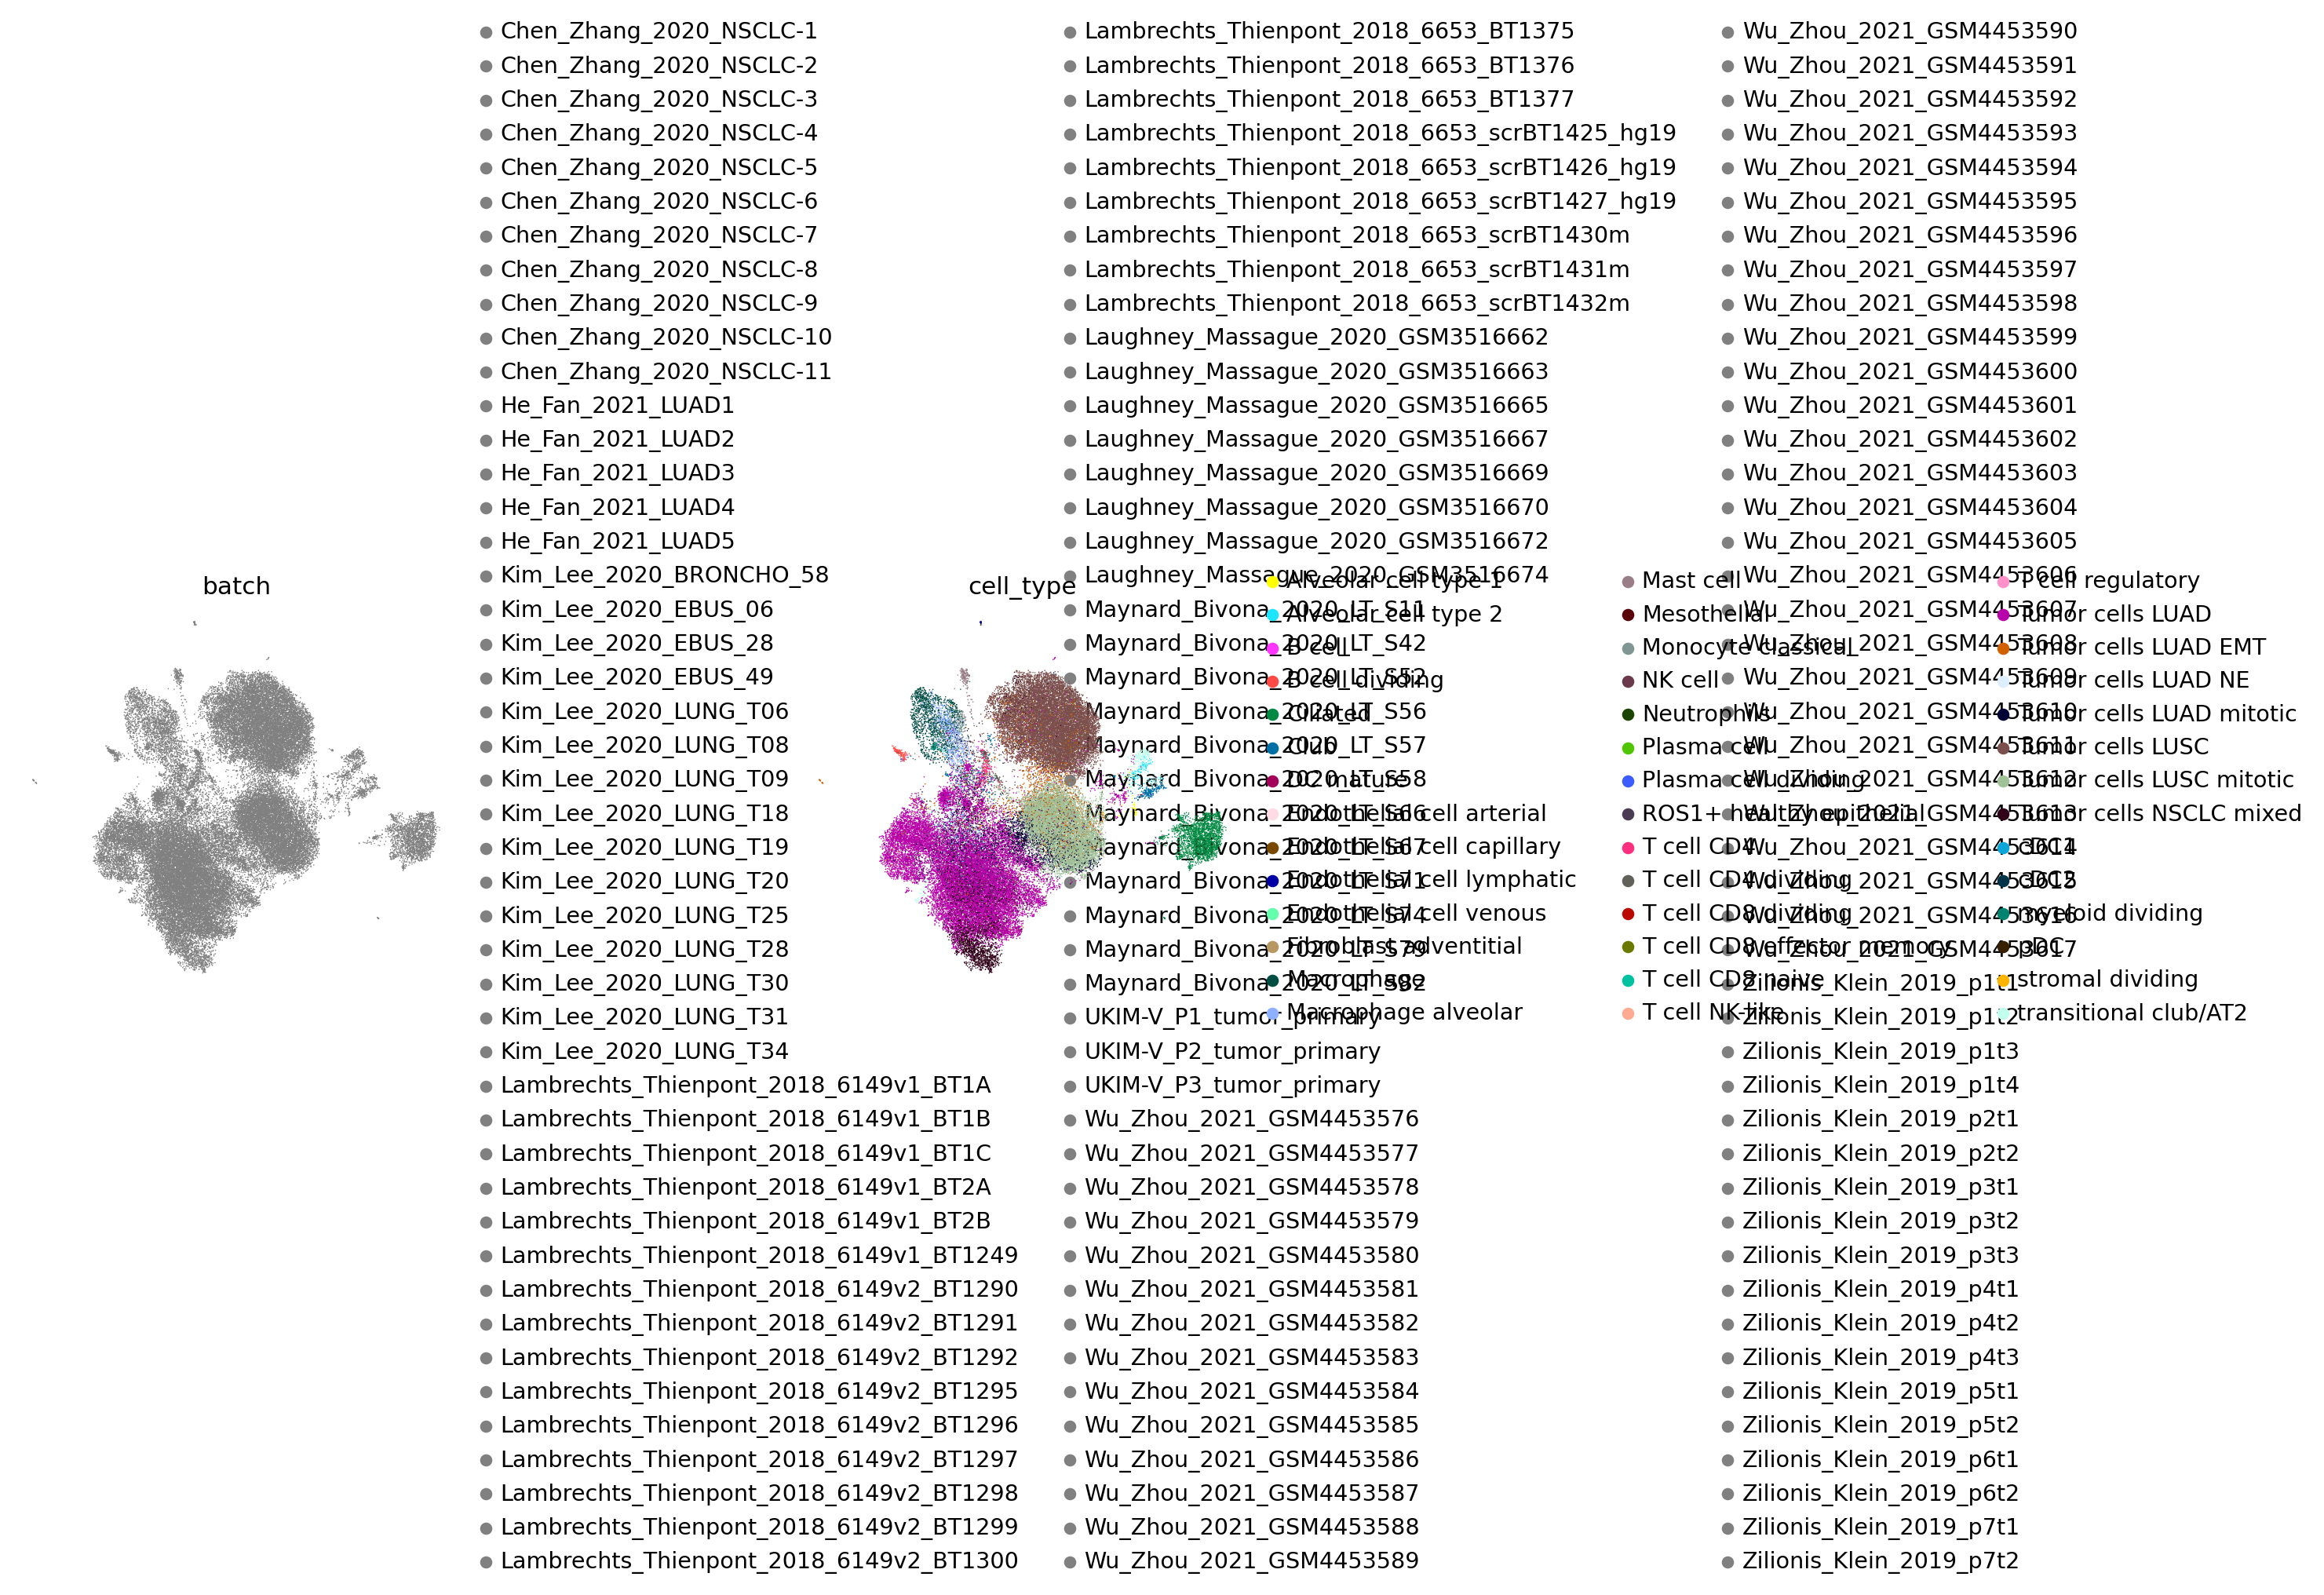

In [111]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [142]:
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

/usr/local/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:189: UserWarning: Category 55 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/usr/local/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:189: UserWarning: Category 11 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/usr/local/lib/python3.11/site-packages/scvi/data/fields/_scanvi.py:58: UserWarning: Category 11 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


Acc: 0.7156204005887247


In [189]:
reference_latent.obs['predictions'] = scanvae2.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.904988161515326


In [133]:
scanvae.__dict__

{'id': '758c1c17-134e-46a5-a36a-4ce4f9e54889',
 '_adata': AnnData object with n_obs × n_vars = 62508 × 5989
     obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'develo

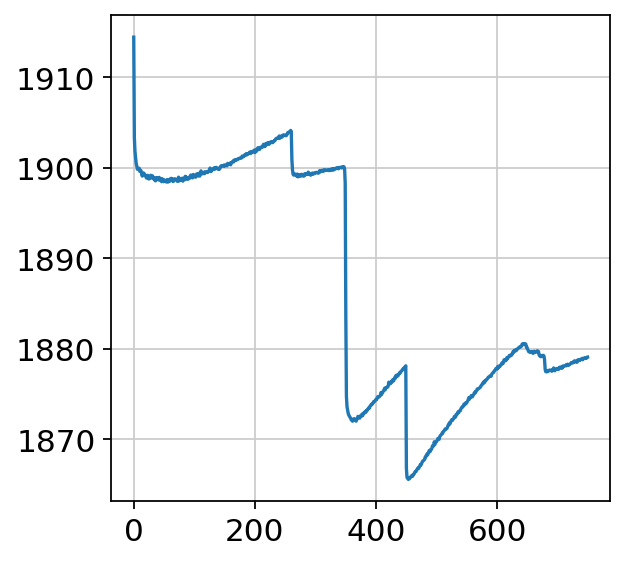

In [219]:
plt.plot(scanvae2.history['train_loss_epoch'])

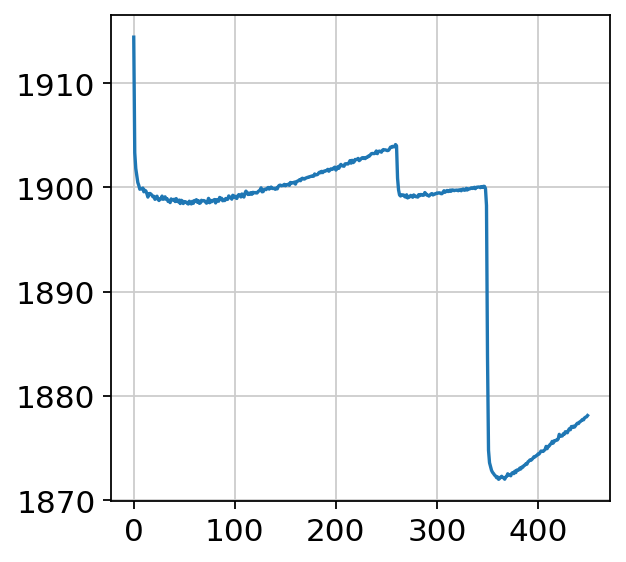

In [185]:
plt.plot(scanvae2.history['train_loss_epoch'])

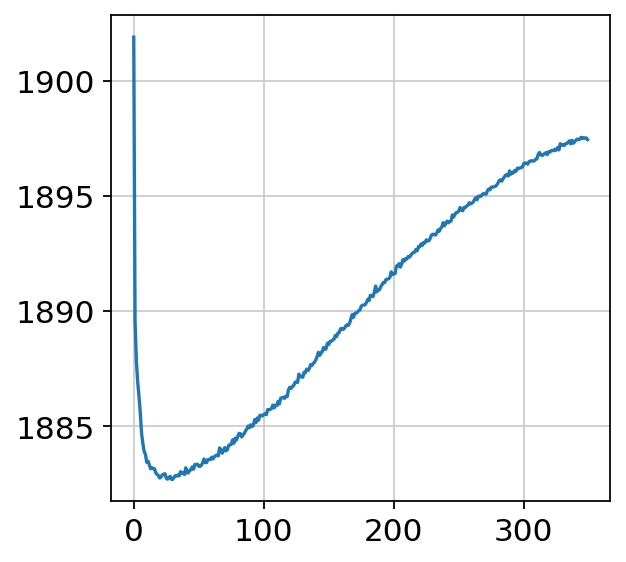

In [119]:
plt.plot(scanvae.history['train_loss_epoch'])

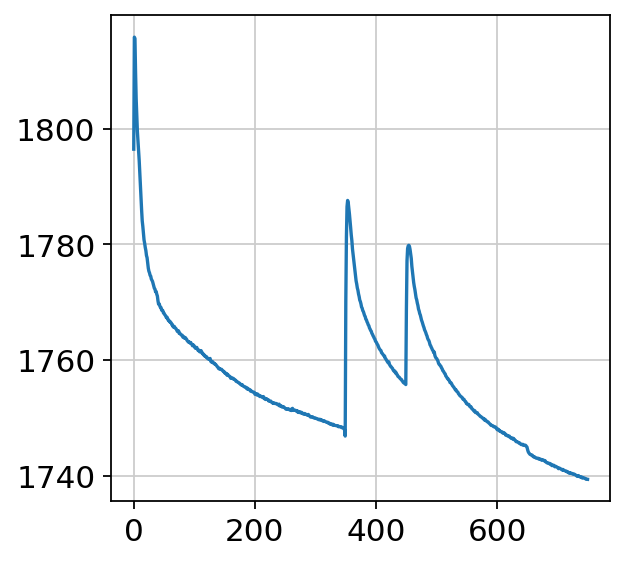

In [191]:
plt.plot(scanvae2.history['elbo_train'])

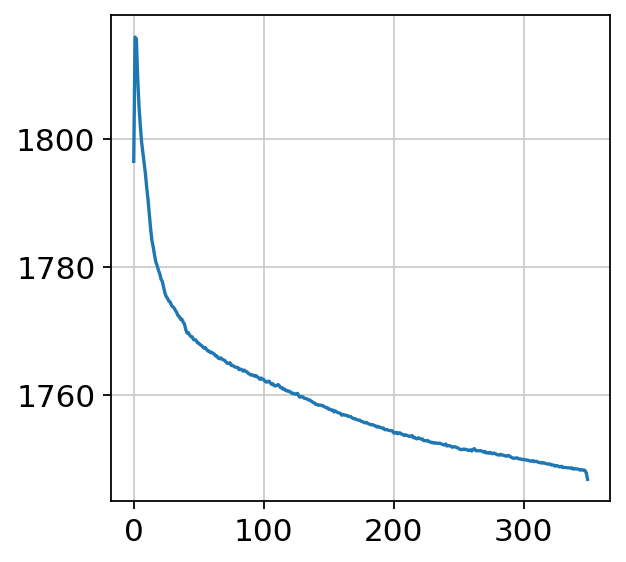

In [141]:
plt.plot(scanvae2.history['elbo_train'])

## Perform surgery on reference model and train on query dataset without cell type labels

In [193]:
ref_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_3layers/'
# target_adata = sc.read_h5ad('/root/datos/maestria/netopaas/luca_explore/surgeries/filtered_Zuani_2024_NSCLC.h5ad')

early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.1,
    "plan_kwargs": {"weight_decay": 0.0},
}
# target_adata.obs[cell_type_key] = scanvae.unlabeled_category_
target_adata.obs[cell_type_key] = 'Unknown'

In [5]:
target_adata.obs.index = 'Zuani_' + target_adata.obs.barcode.astype('string')
target_adata.obs_names_make_unique()

In [6]:
zuani_ensembl = pd.read_csv('/root/datos/maestria/netopaas/zuani_ensembl.csv', index_col=0)
zuani_ensembl

symbol  ensembl_gene_id
MIR1302-2HG  MIR1302-2HG  ENSG00000243485
AL627309.1    AL627309.1  ENSG00000237683
AL627309.3    AL627309.3              NaN
AL627309.4    AL627309.4              NaN
AL732372.1    AL732372.1  ENSG00000256186
...                  ...              ...
AC004556.1    AC004556.1              NaN
AC233755.2    AC233755.2              NaN
AC233755.1    AC233755.1              NaN
AC240274.1    AC240274.1              NaN
FAM231C          FAM231C  ENSG00000268991

[29955 rows x 2 columns]

In [7]:
target_adata.var['symbol'] = target_adata.var.index
target_adata.var['ensembl_gene_id'] = zuani_ensembl.ensembl_gene_id
target_adata.var.index = target_adata.var['ensembl_gene_id']
target_adata.var

n_counts   mito  n_cells_by_counts  mean_counts  \
ensembl_gene_id                                                    
ENSG00000243485       6.0  False                  3     0.000011   
ENSG00000237683     354.0  False                295     0.001117   
NaN                  55.0  False                 50     0.000188   
NaN                  66.0  False                 57     0.000214   
ENSG00000256186     191.0  False                104     0.000406   
...                   ...    ...                ...          ...   
NaN               16627.0  False              11995     0.053654   
NaN                2683.0  False                286     0.009979   
NaN                1195.0  False                349     0.004294   
NaN                2450.0  False               1921     0.007595   
ENSG00000268991       6.0  False                  4     0.000015   

                 pct_dropout_by_counts  total_counts       symbol  \
ensembl_gene_id                                                     
ENSG00000243485              99.998872           3.0  MIR1302-2HG   
ENSG00000237683              99.889082         297.0   AL627309.1   
NaN                          99.981200          50.0   AL627309.3   
NaN                          99.978568          57.0   AL627309.4   
ENSG00000256186              99.960897         108.0   AL732372.1   
...                                ...           ...          ...   
NaN                          95.489974       14270.0   AC004556.1   
NaN                          99.892466        2654.0   AC233755.2   
NaN                          99.868779        1142.0   AC233755.1   
NaN                          99.277719        2020.0   AC240274.1   
ENSG00000268991              99.998496           4.0      FAM231C   

                 ensembl_gene_id  
ensembl_gene_id                   
ENSG00000243485  ENSG00000243485  
ENSG00000237683  ENSG00000237683  
NaN                          NaN  
NaN                          NaN  
ENSG00000256186  ENSG00000256186  
...                          ...  
NaN                          NaN  
NaN                          NaN  
NaN                          NaN  
NaN                          NaN  
ENSG00000268991  ENSG00000268991  

[29955 rows x 8 columns]

In [8]:
target_adata = target_adata[:, ~target_adata.var.index.duplicated(keep='first')].copy() # create a copy to avoid modifying the original object
target_adata.var.index = pd.Index(target_adata.var.index) # convert to a plain Index object, which enforces uniqueness

In [194]:
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata = target_adata,
    # return_reference_var_names=True,
    reference_model = ref_path,
    inplace=False)

INFO     File                                                                                                      
         /datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_3layers/model.pt    
         already downloaded                                                                                        
INFO     Found 93.30439138420438% reference vars in query data.                                                    


In [195]:
adata_query

AnnData object with n_obs × n_vars = 220866 × 5989
    obs: 'sample', 'barcode', 'Source Name', 'Characteristics[tumor grading]', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'stage', 'cell_type_tumor'
    var: 'n_counts', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'symbol', 'ensembl_gene_id'

In [196]:
import scvi

# scvi.settings.batch_size = 1024
scvi.settings.num_workers = 40
model2 = sca.models.SCANVI.load_query_data(
    adata_query,
    ref_path,
    freeze_dropout = True,
)
model2._unlabeled_indices = np.arange(adata_query.n_obs)
model2._labeled_indices = []
print("Labelled Indices: ", len(model2._labeled_indices))
print("Unlabelled Indices: ", len(model2._unlabeled_indices))

INFO     File                                                                                                      
         /datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_3layers/model.pt    
         already downloaded                                                                                        
Labelled Indices:  0
Unlabelled Indices:  220866


In [198]:
model2.train(
    max_epochs=300,
    check_val_every_n_epoch=10,
    batch_size=128,
    **early_stopping_kwargs_surgery
)

INFO     Training for 300 epochs.                                                                                  


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [4:47:31<00:00, 52.19s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.58e+3]

INFO: `Trainer.fit` stopped: `max_epochs=300` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [4:47:31<00:00, 57.51s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.58e+3]


In [ ]:
# model.save(f'{backup_dir}/Deng', overwrite=True)
model = sca.models.SCANVI.load(f'{backup_dir}/Deng3', adata_query)

In [203]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = adata_query.obs[cell_type_key].tolist()
query_latent.obs['batch'] = adata_query.obs[condition_key].tolist()

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 320x320 with 0 Axes>

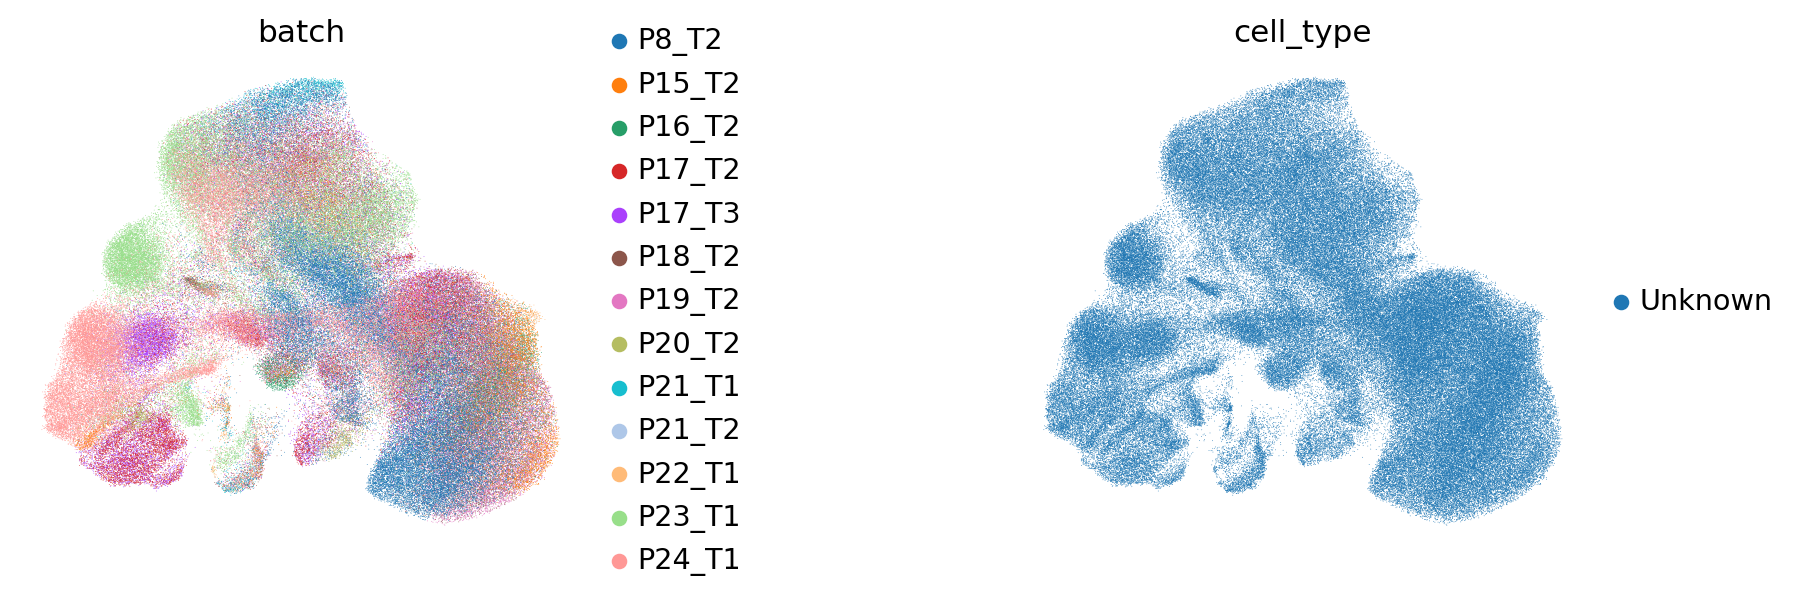

In [204]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

In [161]:
query_latent.obs['predictions'] = model.predict()

In [206]:
query_latent.obs['predictions'] = model2.predict()

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


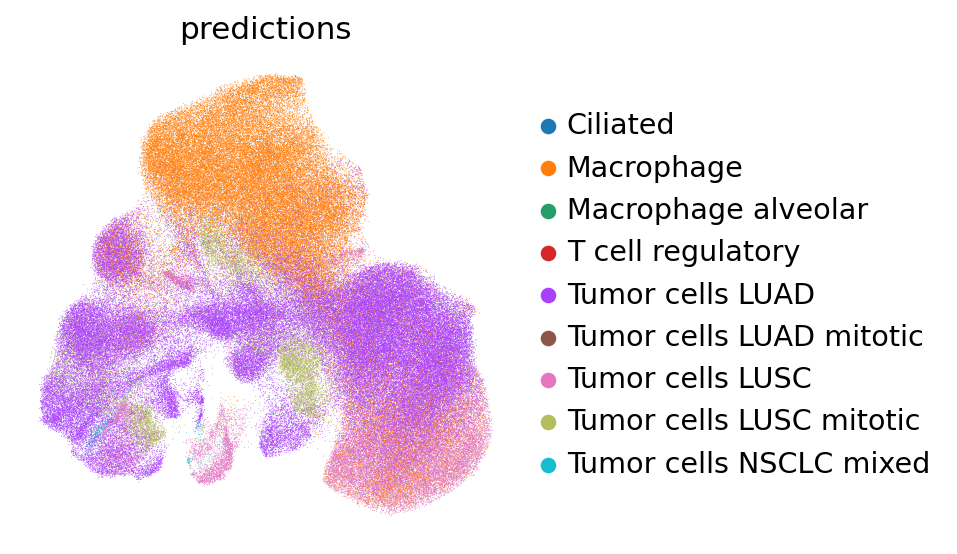

In [207]:
sc.pl.umap(
    query_latent,
    color=["predictions"],
    frameon=False,
    wspace=0.6,
)

## Bad predictions

Predictions are super bad, let's see why.

Inspecting the model we see that the accuracy only achieves a 77% accuracy. But als that the genes used to train the model
have not been filtered for HVG, which can contaminate the predictions.

In [48]:
model.history

{'train_loss_step':       train_loss_step
 epoch                
 0         4955.802246
 1         4786.060547
 2         4809.986328
 3         4840.205566
 4         4917.583984
 ...               ...
 95        4755.180176
 96        4792.571289
 97        4797.835449
 98        4905.572266
 99        5025.675293
 
 [100 rows x 1 columns],
 'train_loss_epoch':       train_loss_epoch
 epoch                 
 0           4985.03125
 1          4888.348633
 2          4865.975098
 3          4856.287109
 4          4850.654785
 ...                ...
 95         4834.439941
 96         4834.461914
 97         4834.493652
 98         4834.500488
 99         4834.586426
 
 [100 rows x 1 columns],
 'elbo_train':         elbo_train
 epoch             
 0      5020.044922
 1      4923.258789
 2      4900.777832
 3      4890.989746
 4      4885.262207
 ...            ...
 95     4861.148926
 96     4861.083496
 97     4861.025879
 98     4860.947754
 99     4860.943848
 
 [100 rows x 1 colum

lets see how the accuracy from the HLCA model fares

In [71]:
from scvi.model.base._utils import _load_saved_files
attr_dict, var_names, model_state_dict, adata_ = _load_saved_files(
    '/root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/',
    load_adata=False, map_location='cpu')
attr_dict

INFO     File /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/model.pt already downloaded   


{'history_': None,
 'init_params_': {'unlabeled_category': 'unlabeled',
  'pretrained_model': None,
  'n_hidden': 128,
  'n_latent': 30,
  'n_layers': 2,
  'dropout_rate': 0.1,
  'dispersion': 'gene',
  'gene_likelihood': 'nb',
  'use_cuda': True,
  'model_kwargs': {'encode_covariates': True,
   'deeply_inject_covariates': False,
   'use_layer_norm': 'both',
   'use_batch_norm': 'none'}},
 'is_trained_': True,
 'semisupervised_history_': defaultdict(list,
             {'accuracy_full_dataset': [0.0065690895221489675,
               0.7643420013076881,
               0.7658982863836975,
               0.7666304555113606,
               0.7669914319184874,
               0.7674698959298207,
               0.7676418705388764,
               0.7678019261156214,
               0.7682020650574838,
               0.7684472565793058,
               0.7684864191140413,
               0.7684932299896474,
               0.7689495586552607,
               0.7691317495777257,
               0.76913

Here we can see that the accruacy of the HCA is still not very high 78%. But the ELBO and KL divergence really does get reduced.
Another thing is that they only use 2000 HVG, I will also adjust that.

ELBO (evidence lower bound optimization) is how well it reconstructs and is an approximation of the posterior porbability of the VAE, KL divergence is
 the divergence of the distribution-- basic concept of statistics.

In [73]:
len(attr_dict['unsupervised_history_'].popitem()[1])

363

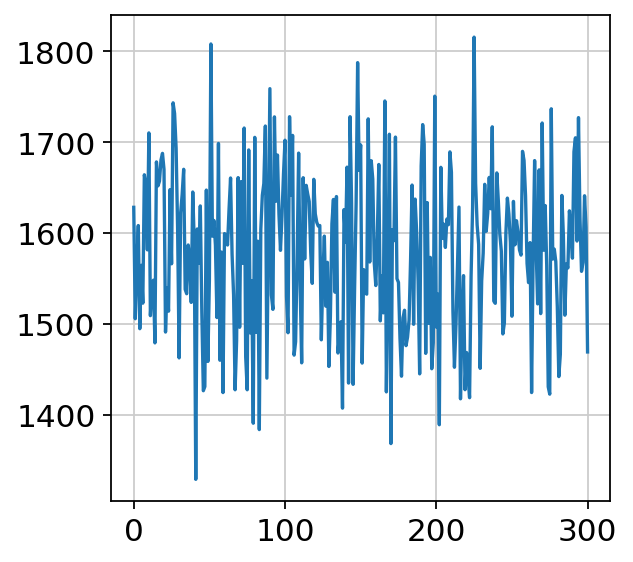

In [210]:
plt.plot(model2.history['train_loss_step'])

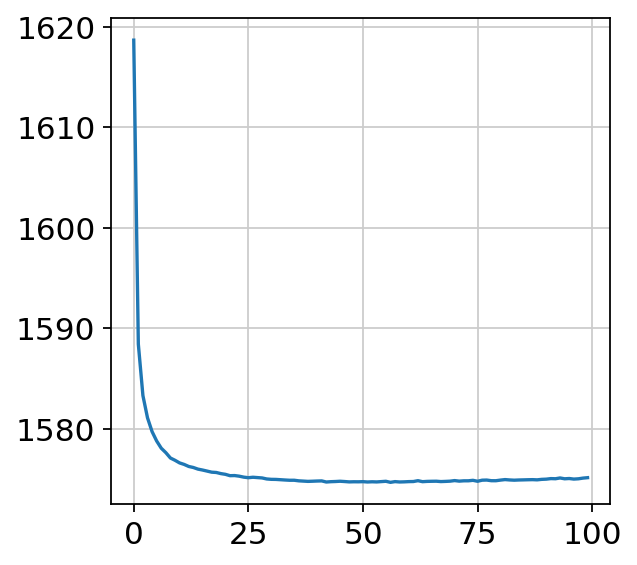

In [187]:
plt.plot(model2.history['train_loss_epoch'])

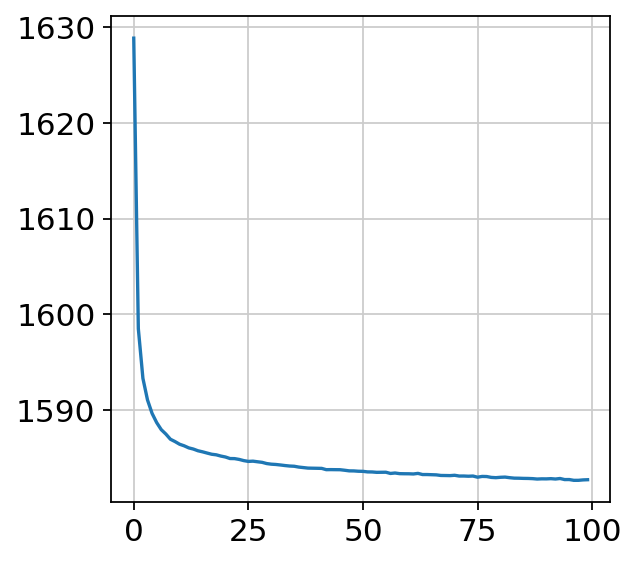

In [181]:
plt.plot(model2.history['elbo_train'])

We can also see that it has lots of epochs so no early stopping. That will be very necessary.

## Save predictions

In [215]:
adata_query.obs['cell_type_tumor'] = query_latent.obs['predictions']

In [216]:
adata_query.obs.to_csv('zuani_predicted.csv')

In [ ]:
query_latent_tumor = query_latent[~query_latent.obs.batch.str.contains('P05|N')]

In [ ]:
df = query_latent_tumor.obs.groupby(["cell_type", "predictions"]).size().unstack(fill_value=0)
# df
norm_df = df / df.sum(axis=0)
norm_df.filter(like='Tumor')

predictions  Tumor cells
cell_type               
Unknown              1.0

In [20]:
query_latent.obs['predictions'].value_counts()

Tumor cells LUSC            137877
Tumor cells LUAD             61070
Tumor cells LUSC mitotic     18098
Ciliated                      3821
Name: predictions, dtype: int64

In [220]:
surgery_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/Zuani'
model.save(surgery_path, overwrite=True)